# Lyrix
## Semester project - Report
<b> Olivier Couque & Emma Lejal Glaude <br>
Supervisor: Panayotis Smeros, Lab: LSIR </b><br>

The goal of this project is to merge lyrics from two different music genres. <br>
Table of content:
1. [Data Gathering](#data)
2. [Data Cleaning](#cleaning)
3. [Preprocessing](#process)
4. [MUSE](#muse)
5. [Neural Network](#nn)
6. [Webpage](#site)

<a id="top"></a>

### Litterature

Regarding this project we had the following sources:
- https://github.com/robbiebarrat/rapping-neural-network
- http://www.encore.ai
- https://github.com/tonybeltramelli/Deep-Lyrics
- https://raplyrics.eu

[Go to top](#top)

<a id="data"></a>

In [47]:
#Usefull imports
import numpy as np
import pandas as pd
from langdetect import detect
import matplotlib.pyplot as plt
import time
import re
import pickle
import requests
from bs4 import BeautifulSoup
import string
import sys
import codecs
import json
import spacy

## Data Gathering

To gather data we had multiple difficulties. First of all we need entire lyrics and not only the bag of words contained in the lyrics. However this is difficult to get as the lyrics are protected by Intellectual Property. Consequently there are no open database with entire lyrics available. On top of this, we need the lyrics classified according with the different musical genres. <br>
We started to look for datasets and encountered the One Million Song Dataset, unfortunately, this dataset contains only the bag of words. Afterwards we considered the MusicBrainz dataset but realized we could only get about a third of the lyrics per song. <br>
We turned to the Kaggle website to look for datasets and found the following ones :
- https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics

In [2]:
filepath = "kaggle_lyrics.csv" #lyrics
lyrics_df = pd.read_csv(filepath)
lyrics_df.set_index('index', inplace = True)

In [3]:
print("Number of songs: {}".format(len(lyrics_df)))
lyrics_df.head()

Number of songs: 362237


,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [4]:
lyrics_df.dropna(axis = 'index', subset = ['lyrics'], inplace = True)
print("Number of songs WITH available lyrics: {}".format(len(lyrics_df)))

Number of songs WITH available lyrics: 266557


In [5]:
artists = set(lyrics_df["artist"])
genres = set(lyrics_df["genre"])

In [6]:
print("Genres: {}".format(genres))
print("Number of artists: {}".format(len(artists)))

Genres: {'Rock', 'R&B', 'Indie', 'Jazz', 'Pop', 'Folk', 'Other', 'Electronic', 'Metal', 'Country', 'Hip-Hop', 'Not Available'}
Number of artists: 14543


In [7]:
songs_per_genre = {}
total_songs = 0
unknown_songs = 0
for genre in genres:
    nb = len(lyrics_df[lyrics_df['genre'] == genre])
    songs_per_genre[genre] = nb
    total_songs += nb
    if genre == "Not Available" or genre == "Other":
        unknown_songs += nb
songs_per_genre

{'Country': 14387,
 'Electronic': 7966,
 'Folk': 2243,
 'Hip-Hop': 24850,
 'Indie': 3149,
 'Jazz': 7971,
 'Metal': 23759,
 'Not Available': 23941,
 'Other': 5189,
 'Pop': 40466,
 'R&B': 3401,
 'Rock': 109235}

In [8]:
unknown_songs/total_songs

0.10928244240443882

In [9]:
total_songs

266557

Use the detect library to detect the main language of each song and remove the songs that are detected as NOT english

In [ ]:
def language_of_lyrics(lyrics):
    try:
        lang = detect(lyrics)
        return lang
    except:
        return "no lang"

#lyrics_df['language'] = lyrics_df.apply(lambda row: language_of_lyrics, axis = 1)
list_langs = []
for i, row in lyrics_df.iterrows():
    if i % 1000 == 0:
        print(i)
    lang = language_of_lyrics(row['lyrics'])
    list_langs.append(lang)

In [ ]:
lyrics_df['language'] = list_langs

In [ ]:
lyrics_df.to_csv("kaggle_lyrics_with_lang.csv")

In [11]:
lyrics_df = pd.read_csv("kaggle_lyrics_with_lang.csv")

FileNotFoundError: File b'kaggle_lyrics_with_lang.csv' does not exist

In [ ]:
english_df = lyrics_df[lyrics_df['language'] == 'en']
print(len(english_df))
english_df.head()

We will have a look at the distribution of the lyrics that we have. First we need to identify the main genre per artist. To do this we will use the Spotify API.

In [13]:
import spotipy
import spotipy.oauth2 as oauth2
import spotipy.util as util

In [15]:
client_id = "c829ff34022d4c3a9e65c30c10623765"
client_secret = "8e998357ebf04fe092edab4915946e00"

credentials = oauth2.SpotifyClientCredentials(client_id, client_secret)

token = credentials.get_access_token()
sp = spotipy.Spotify(auth=token)

In [16]:
filepath = "mb_music.csv" #we use a file from MusicBrainz to gather artists names
lyrics_df = pd.read_csv(filepath)
useful_df = lyrics_df[['artist.name', 'terms']]
useful_df.head()

,artist.name,terms
0,Casual,hip hop
1,The Box Tops,blue-eyed soul
2,Sonora Santanera,salsa
3,Adam Ant,pop rock
4,Gob,pop punk


In [18]:
with open ('en_artists_from_musicbrainz', 'rb') as fp:
    english_artist = pickle.load(fp)

In [19]:
len(english_artist)

365691

In [20]:
def get_artist_genres(artist_name):
    """ Fetch on Spotify the genres of the artist"""
    query = sp.search(q='artist:' + artist_name, type='artist')
    if len(query['artists']['items']) > 0:
        genres = query['artists']['items'][0]['genres'] # list: ["pop rock", "hard rock", "alternative rock"...]
        return genres
    else:
        #print("{} not on Spotify".format(artist_name))
        return []

In [21]:
def refresh_token():
    token = credentials.get_access_token()
    sp = spotipy.Spotify(auth=token)

In [ ]:
artist_genre = []
artists = english_artist
artists_with_error = []

start = time.time()
print("Initial number of artists: {}".format(len(artists)))
for i, artist in enumerate(artists):
    if i % 500 == 0:
        print(i)
    if (time.time() - start)>= 3600:
        start = time.time()
        refresh_token()
    try:
        genres = get_artist_genres(artist)
        if len(genres) > 0:
            artist_genre.append([artist, genres])
    except :
        artists_with_error.append(artist)
        #print("error for artist : ", artist)
print("Number of artists with genres on Spotify: {}".format(len(artist_genre)))

In [ ]:
artist_genres_df = pd.DataFrame(artist_genre, columns = {'artist', 'genre'})
artist_genres_df = artist_genres_df.drop_duplicates('artist')
artist_genres_df.to_csv("artist_genre.csv", sep=';')

In [22]:
MAIN_GENRES = {'indie', 'metal', 'electronic', 'hip hop', 'country', 'jazz', 'pop', 'rock'}

artist_path = "artist_genre.csv"
artist_genres_df = pd.read_csv(artist_path, sep = ';', usecols = ["artist", "genre"])
artist_genres_df.head() # The genre field is a string and not a list

,artist,genre
0,Black Eyed Peas,"['dance pop', 'pop', 'pop rap']"
1,Jimmy Hughes,['southern soul']
2,Joy Division,"['alternative rock', 'art rock', 'dance rock',..."
3,Mint Condition,"['dance pop', 'funk', 'hip pop', 'neo soul', '..."
4,Plump DJs,"['big beat', 'breakbeat', 'electronic', 'nu sk..."


In [23]:
def get_main_genre(genres, main_genres = MAIN_GENRES):
    """ Count occurences of main genres terms in the genres string"""
    main_genres_occ = [(g, len(re.findall(g, genres))) for g in main_genres if len(re.findall(g, genres)) > 0] # list: [(rock, 3), (pop, 1), (hard, 1)...]
    
    if len(main_genres_occ) > 0:
        max_genre = sorted(main_genres_occ, key = lambda x: x[1], reverse = True)[0][0]
        return max_genre
    else:
        return "No main genre"

In [ ]:
simple_genres = []
for i, artist_row in artist_genres_df.iterrows():
    genres = artist_row['genre']
    main_genre = get_main_genre(genres)
    simple_genres.append(main_genre)

col_name = "main genre"
if col_name in list(artist_genres_df.columns):
    artist_genres_df.drop(col_name, inplace = True)
artist_genres_df[col_name] = simple_genres
artist_genres_df.head()

In [ ]:
# Save the dataframe with main genre in a csv file
useful_df = genres_df[["artist", "main genre"]]
useful_df.to_csv("artists_main_genre.csv", index = False)

In [25]:
artist_genres_df = pd.read_csv("artists_main_genre.csv")

Number of artists: 1796
Number of artists with main genre: 1796
Ratio: 1.0


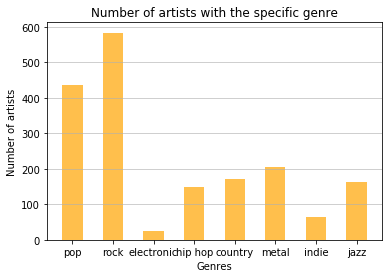

In [26]:
print("Number of artists: {}".format(len(artist_genres_df)))
genres_df = artist_genres_df[artist_genres_df["main genre"] != "No main genre"]
print("Number of artists with main genre: {}".format(len(genres_df)))
print("Ratio: {}".format(len(genres_df) / len(artist_genres_df)))

n, bins, patches = plt.hist(x = list(genres_df["main genre"]), bins=np.arange(0,len(MAIN_GENRES) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of artists')
plt.title('Number of artists with the specific genre')
plt.show()

We can see that we have enough songs for the rock genre. We will try to complete this dataset with other songs.

In [27]:
english_df = pd.read_csv("lyrics_cleaned.csv")
artist_genre_df = pd.read_csv("artists_main_genre.csv")
artist_genre_df.head()

,artist,main genre
0,Black Eyed Peas,pop
1,Joy Division,rock
2,Mint Condition,pop
3,Plump DJs,electronic
4,Jope Ruonansuu,pop


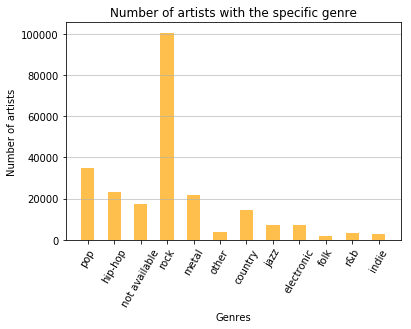

In [28]:
n, bins, patches = plt.hist(x = list(english_df["genre"]), bins=np.arange(0,len(set(english_df["genre"])) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of artists')
plt.title('Number of artists with the specific genre')
plt.xticks(rotation=60)
plt.show()

In [29]:
main_lyrics_df = english_df[english_df['genre'].isin(MAIN_GENRES)]
print("Ratio of lyrics kept from main genres: {}".format(len(main_lyrics_df) / len(english_df)))

# Give same format of artist names in both dataframes:
main_lyrics_df['artist'] = main_lyrics_df['artist'].apply(lambda a: a.replace('-', ' ').lower()) # beyonce-knowles -> beyonce knowles
artist_genre_df['artist'] = artist_genre_df['artist'].apply(lambda a: a.replace('-', ' ').lower())
# Create dictionary of artist - genre
artist_genre_dict = dict(zip(list(artist_genre_df['artist']), list(artist_genre_df['main genre'])))

# Get the set of artists for which we don't already have the lyrics
artists_to_fetch = set(artist_genre_df['artist']).difference(set(main_lyrics_df['artist']))
print("Artists to fetch number: {} , ratio: {}".format(len(artists_to_fetch), len(artists_to_fetch) / len(set(artist_genre_df['artist']))))

Ratio of lyrics kept from main genres: 0.7912138650682717
Artists to fetch number: 1461 , ratio: 0.81438127090301


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We will try to scrap a first website (https://www.lyricsfreak.com) to complete the lyrics.

In [31]:
url_lyricsfreak = 'https://www.lyricsfreak.com'

In [32]:
def get_lyrics_from_link(url):
    response = requests.get(url).content
    soup_lyrics = BeautifulSoup(response, "lxml")
    # Get lyrics from the link
    lyrics_html = soup_lyrics.find_all('div', class_= "dn") # found by inspecting the url
    try:
        lyrics = str(lyrics_html).split('content_h">')[1].split('</div>')[0]
    except IndexError:
        # Some lyrics have an url but acces is restricted
        print("Lyrics restricted for URL {}".format(url))
        return ''
    """Do all the cleaning on the lyrics here: maybe keep if only english ?"""
    # Replace line jump (<br/>) with puctuation .
    lyrics_cleaned = lyrics.replace('<br/>', '. ')
    return lyrics_cleaned


# Given an artist name, get all his songs and lyrics available on lyricsfreak
def get_songs_from_artist(artist_name, genre):
    # Convert artist name to right format for the url
    artist = artist_name.lower()
    first_char = artist[0]
    artist_url = artist.replace(' ', '+') # Name with spaces
    url = url_lyricsfreak + '/' + first_char + '/' + artist_url + '/'
    # Get HTML info on URL
    response = requests.get(url).content
    soup = BeautifulSoup(response, "lxml")
    # Get all songs from that artist on the website
    songs_html = soup.find_all("td", "colfirst") # parameters found by inspecting the url
    
    songs_name_link = []
    for song in songs_html:
        song = str(song)
        if artist_url + '/' in song:
            link = song.split(artist_url + '/')[1].split('"')[0]
            song_name = song.split('title="')[1].split(' Lyrics"')[0]
            # Fetch the lyrics for this song
            url_lyrics = url + link
            lyrics = get_lyrics_from_link(url_lyrics)
            if lyrics != '':
                # Get same format as the rows of the main_lyrics_df
                year = None
                language = None
                songs_name_link.append([song_name, year, artist_name, genre, lyrics, language])
    return songs_name_link

In [33]:
test_artists = ['Northlane', 'Mac Miller']
test_dict = {test_artists[0]: 'metal', test_artists[1]: 'hip hop'}
lyrics_test = []

# Create empty dataframe to store results
df = pd.DataFrame(columns = list(main_lyrics_df.columns))
for artist in test_artists:
    genre = test_dict[artist]
    artist_lyrics = get_songs_from_artist(artist, genre)
    print("{} - Number of lyrics found: {}".format(artist, len(artist_lyrics)))
    lyrics_test.append(artist_lyrics)

Northlane - Number of lyrics found: 0
Mac Miller - Number of lyrics found: 0


In [34]:
songs_per_genre = {}
genres = [g.lower() for g in genres]
for genre in genres:
    if genre == "hip-hop":
        songs_per_genre["hip hop"] = len(english_df[english_df["genre"] == genre])
    else :
        songs_per_genre[genre] = len(english_df[english_df["genre"] == genre])
print(songs_per_genre)
print(MAIN_GENRES)

{'hip hop': 23035, 'indie': 2975, 'metal': 21532, 'electronic': 7016, 'r&b': 3348, 'rock': 100565, 'not available': 17579, 'country': 14252, 'pop': 34807, 'jazz': 7351, 'folk': 1790, 'other': 3989}
{'hip hop', 'indie', 'metal', 'rock', 'country', 'electronic', 'pop', 'jazz'}


In [36]:
artists_to_fetch = set(artist_genre_df['artist']).difference(set(main_lyrics_df['artist']))
print("Total length of artists to fetch: {}".format(len(artists_to_fetch)))

genres_to_fetch = ["metal", "jazz", "country","hip hop", "pop"]

artists_to_fetch = [a for a in artists_to_fetch if artist_genre_dict[a] in genres_to_fetch]
print("Length of artists to fetch : {}".format(len(artists_to_fetch)))

Total length of artists to fetch: 1461
Length of artists to fetch : 938


Let's fetch all the songs for all the artists for which we don't have their lyrics in the english_df dataframe. In order to get approximately the same number of songs for each genre, we will set a threshold (e.g. 50'000 songs). Once we have fetched online this threshold from a particular genre we make sure not to fetch any more songs from following artists of this genre

In [ ]:
songs_per_genre_copy = songs_per_genre.copy()
THRESHOLD = 50000
# Create empty dataframe to store results
new_lyrics_df = pd.DataFrame(columns = list(main_lyrics_df.columns))

for i, artist in enumerate(artists_to_fetch):
    if i % 20 == 19:
        print("Percentage Completion: {}% , Lyrics Obtained: {}".format(100*i / len(list(artists_to_fetch)), len(new_lyrics_df)))
        secs_sleep = 60
        print("Now sleeping {} seconds".format(secs_sleep))
        time.sleep(secs_sleep)
    genre = artist_genre_dict[artist]
    nbr_songs_of_genre = songs_per_genre_copy[genre]
    if nbr_songs_of_genre < THRESHOLD:
        artist_lyrics = get_songs_from_artist(artist, genre)
        if len(artist_lyrics) == 0:
            print("Artist {} not found on lyricsfreak".format(artist))
        else:
            list_to_df = pd.DataFrame(artist_lyrics, columns = list(main_lyrics_df.columns))
            new_lyrics_df = new_lyrics_df.append(list_to_df)
            songs_per_genre_copy[genre] += len(artist_lyrics)

In [ ]:
new_lyrics_df.to_csv("kaggleDataset/lyrics_augmented.csv", index = False)

We will now try to scrap another website, which is providing the genre classification: https://www.lyrics.com

In [37]:
url = 'https://www.lyrics.com/genres.php?genre='
genres = ['Pop', 'Hip%20Hop','Folk,%20World,%20__%20Country', 'Jazz', 'Rock']

In [38]:
def get_artist(div):
    return div.find_all('p', class_ = "lyric-meta-album-artist")[0].getText()

In [39]:
def get_lyrics_from_url(lyrics_url):
    r = requests.get('https://www.lyrics.com/' + lyrics_url).content
    soup = BeautifulSoup(r, "lxml")
    try : 
        l = soup.find_all('pre')[0].getText()
    except : 
        l = 'NaN'
    return l

In [40]:
def get_title_url(div):
    data = div.find_all('p', class_= "lyric-meta-title")[0]
    lyrics_url = data.find_all('a', href = True)[0]['href']
    title = data.getText()
    return title, lyrics_url

In [41]:
def get_artist_from_page(df, genre, nb):
    page_url = url + genre + '&p=' + str(nb)
    resp = requests.get(page_url).content
    soup = BeautifulSoup(resp, "lxml")
    content = soup.find_all('div', class_= "lyric-meta col-sm-6 col-xs-6")
    for c in content:
        t, l = get_title_url(c)
        df.loc[len(df)] = [t, get_artist(c), genre, l]
    return df

In [ ]:
MIN_PAGES = 3000
MAX_PAGES = 4681
lyrics_com_df = pd.DataFrame(columns=['title','artist', 'genre', 'lyrics_url'])

In [ ]:
for genre in genres:
    for page in range(MIN_PAGES, MAX_PAGES):
        try :
            get_artist_from_page(lyrics_com_df, genre, page)
            print('finished genre : ', genre, ' page : ', page)
        except :
            time.sleep(10)
            get_artist_from_page(lyrics_com_df, genre, page)

In [ ]:
lyrics_com_df = lyrics_com_df.drop_duplicates('title')
lyrics_com_df.head()

In [ ]:
def get_lyrics(lyrics_com_url):
    l = ''
    while l == '':
        try:
            l = get_lyrics_from_url(lyrics_com_url)
        except:
            print("Slept for : ", lyrics_com_url)
            time.sleep(5)
            continue
    return l

In [ ]:
lyrics_com_df['lyrics'] = lyrics_com_df['lyrics_url'].map(lambda x : get_lyrics(x))

In [ ]:
lyrics_com_df = lyrics_com_df.dropna(axis = 1)
lyrics_com_df = lyrics_com_df.drop_duplicates('lyrics')  
lyrics_com_df.head(10)

In [ ]:
genre_dict = {'Pop': 'pop', 'Hip%20Hop' : 'hip hop','Folk,%20World,%20__%20Country': 'country', 'Jazz':'jazz', 'Rock':'rock'}

In [ ]:
new_lyrics_df = lyrics_com_df.drop('lyrics_url', axis = 1)
new_lyrics_df['genre'] = new_lyrics_df['genre'].map(lambda x : genre_dict[x])
new_lyrics_df.to_csv("lyrics_com.csv", index = False)

Merge all the different files gathered

In [ ]:
final_df = pd.concat([oli_df, pd.read_csv(emma_files[0]), pd.read_csv(emma_files[1]), 
                      pd.read_csv(emma_files[2]), pd.read_csv(emma_files[3]),
                      pd.read_csv(emma_files[4]),pd.read_csv(emma_files[5]),pd.read_csv(emma_files[6]),
                     pd.read_csv('lyrics_jazz.csv'), pd.read_csv('lyrics_metal.csv')], ignore_index=True)

In [ ]:
final_df = final_df.drop_duplicates()
final_df = final_df.dropna(subset = ['lyrics'])

In [ ]:
def adapt_genre(x):
    if x == 'hip-hop':
        return 'hip hop'
    elif x =='folk':
        return 'country'
    else:
        return x

final_df['genre'] = final_df['genre'].map(lambda x: adapt_genre(x))

In [ ]:
final_df['genre'].value_counts()

In [ ]:
def clean_name(x):
    try:
        return x.lower().replace(' ', '-')
    except:
        return x

In [ ]:
final_df['title'] = final_df['title'].map(lambda x : clean_name(x))
final_df['artist'] = final_df['artist'].map(lambda x : clean_name(x))

In [ ]:
final_df['lang'] = final_df['lyrics'].map(lambda l : language_of_lyrics(l))

In [ ]:
en_df = final_df[final_df['lang'] == 'en']
en_df = en_df.drop(['lang'], axis = 1)
print(len(en_df))
en_df.head()

In [ ]:
en_df.to_csv("full_en_lyrics.csv", index= False) # LYRICS FINAL du 7 novembre ??

[Go to top](#top)

<a id="cleaning"></a>

## Data Cleaning

In [42]:
filepath = "lyrics_final.csv"
lyrics_df = pd.read_csv(filepath)
lyrics_df = lyrics_df.drop(['language'], axis = 1)
print(len(lyrics_df))
lyrics_df.head()

317015


,artist,genre,lyrics,song,year
0,beyonce-knowles,pop,"Oh baby, how you doing?\r\r\r\r\r\nYou know I'...",ego-remix,2009.0
1,beyonce-knowles,pop,"playin' everything so easy,\r\r\r\r\r\nit's li...",then-tell-me,2009.0
2,beyonce-knowles,pop,If you search\r\r\r\r\r\nFor tenderness\r\r\r\...,honesty,2009.0
3,beyonce-knowles,pop,"Oh oh oh I, oh oh oh I\r\r\r\r\r\n[Verse 1:]\r...",you-are-my-rock,2009.0
4,beyonce-knowles,pop,"Party the people, the people the party it's po...",black-culture,2009.0


--> Remove [...], {...} and (....) and x(digit)

This information gives structure for the singer but not usefull for lyrics. This is [Chorus], choir in parentheses, x2 etc. <br>
To test regex expressions : https://regex101.com

In [44]:
regex_bracket = re.compile("\[(.*?)\]")
regex_parentheses = re.compile("\((.*?)\)")
regex_curly_bracket = re.compile("\{(.*?)\}")
regex_timesx = re.compile("x[0-9]")

def split_words_with_upper(l):
    words = l.split(' ')
    for j, w in enumerate(words):
        idx = -1
        if re.match('[a-z]+[A-Z]+', w):
            for i, c in enumerate(w):
                if c.isupper():
                    idx = i
        if idx != -1:
            words[j] = w[:idx] + ' ' + w[idx:]
    return ' '.join(words)


def clean_structure_words(l):
    res= regex_bracket.sub('', l)
    res = regex_parentheses.sub('', res)
    res = regex_curly_bracket.sub('', res)
    res = regex_timesx.sub('', res)
    res = split_words_with_upper(res)
    res = res.lower()
    return res

In [ ]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x : clean_structure_words(x))
lyrics_df.tail()

--> Remove . , ! ? ... ---
- We want to keep the * as this represents some swear words in english
- We want to keep the ' as this is part of many words in english, especially when words are cropped, ie 'Cause 
- Otherwise punctuation is not meaningful

In [ ]:
chars_to_keep = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ* \n"

def clean_punctuation(l):
    #res = regex_punct.sub('', l)
    res = re.sub(' +', ' ', l)#res)
    res = res.replace("'", ' ') # replace the quotes with a space.
    res = ''.join(char for char in res if char in chars_to_keep)
    return res

In [ ]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x : clean_punctuation(x))
lyrics_df.tail()

[Go to top](#top)

<a id="process"></a>

## Data Preprocessing

Create FastText vectors : https://fasttext.cc/docs/en/unsupervised-tutorial.html

In [ ]:
# First create a txt file with the lyrics
f = open("lyrics.txt", "w+")
for i, r in lyrics_df.iterrows():
    f.write(r['lyrics'])
    
f.close()

In [ ]:
# Generate embeddings
! ./fasttext skipgram -input lyrics.txt -output model_full_lyrics

In [ ]:
file_vec = 'model_lyrics3.vec'
file_bin = 'model_lyrics3.bin'

In [ ]:
# Load embeddings
def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

In [ ]:
word_embeddings, vocabulary = load_embeddings(file_vec)
vocabulary = list(vocabulary)

In [ ]:
#If necessary
def get_embedding_for_missing_word(w, file_bin = file_bin):
    #data = ! echo $w | ./fasttext print-word-vectors model_lyrics.bin #emma
    data = ! echo $w | ./fasttext print-word-vectors $file_bin #oli
    emb = np.zeros(100)
    for i, x in enumerate(data[0].split( )[1:]):
        try:
            emb[i] = float(x)
        except ValueError:
            print(data[0])
    return emb

In [ ]:
get_embedding_for_missing_word("we re")

--> Create column with indicator of last word of line

In [48]:
def generate_embedding_for_lyrics(l):
    sentences = l.split('\n')
    embedding = []
    for s in sentences:
        words = s.split(' ')
        for i, w in enumerate(words):
            if len(w)>0:
                try : 
                    idx = vocabulary.index(w)
                    vector = word_embeddings[idx]
                except ValueError : 
                    #print("Word not found :", repr(w))
                    vector = get_embedding_for_missing_word(w)
                if i == (len(words)-1) :
                    vector = np.append(vector, 1)
                else :
                    vector = np.append(vector, 0)
                vector = np.append(w, vector)
                embedding.append(vector)
                
    return embedding

In [ ]:
generate_embedding_for_lyrics("oh baby how you doing\nyou know im gonna cut right to the chase")

--> Create column with type of word (noum, verb, etc)

In [ ]:
en_nlp = spacy.load('en')

ADJ: adjective ADP: adposition ADV: adverb AUX: auxiliary verb CONJ: coordinating conjunction DET: determiner INTJ: interjection NOUN: noun NUM: numeral PART: particle PRON: pronoun PROPN: proper noun PUNCT: punctuation SCONJ: subordinating conjunction SYM: symbol VERB: verb X: other

In [49]:
def generate_pos_for_lyrics(l):
    doc = en_nlp(l)
    embedding = []
    for i in range(len(doc)):
        print(doc[i], doc[i].pos_)
        type_ = doc[i].pos_
        if type_ != 'SPACE' and type_ != 'PART':
            embedding.append(type_)
    return embedding

In [50]:
def generate_pos_for_word(w):
    doc = en_nlp(w)
    return doc[0].pos_

In [51]:
pos_to_idx = {'ADJ': 0, 'ADP': 1, 'ADV':2,'AUX': 3,'CONJ': 4,'CCONJ': 5,'DET': 6, 'INTJ': 7, 'NOUN': 8,
              'NUM': 9, 'PART': 10,'PRON':11, 'PROPN': 12, 'PUNCT': 13, 'SCONJ': 14, 'SYM': 15, 
              'VERB': 16, 'X': 17}

In [ ]:
def merge_embedding_pos(l):
    embedding = generate_embedding_for_lyrics(l)
    for i in range(len(embedding)):
        w = embedding[i][0]
        if w != '\n':
            pos = generate_pos_for_word(str(w))
            bin_vector = np.zeros(18)
            bin_vector[pos_to_idx[pos]] = 1
            embedding[i] = np.append(embedding[i], bin_vector)
    return embedding

--> Create column with Entity Recognition

In [ ]:
nlp = spacy.load('en_core_web_sm')

Entity types : <br>
PERSON	People, including fictional.<br>
NORP	Nationalities or religious or political groups.<br>
FAC	Buildings, airports, highways, bridges, etc.<br>
ORG	Companies, agencies, institutions, etc.<br>
GPE	Countries, cities, states.<br>
LOC	Non-GPE locations, mountain ranges, bodies of water.<br>
PRODUCT	Objects, vehicles, foods, etc. (Not services.)<br>
EVENT	Named hurricanes, battles, wars, sports events, etc.<br>
WORK_OF_ART	Titles of books, songs, etc.<br>
LAW	Named documents made into laws.<br>
LANGUAGE	Any named language.<br>
DATE	Absolute or relative dates or periods.<br>
TIME	Times smaller than a day.<br>
PERCENT	Percentage, including "%".<br>
MONEY	Monetary values, including unit.<br>
QUANTITY	Measurements, as of weight or distance.<br>
ORDINAL	"first", "second", etc.<br>
CARDINAL	Numerals that do not fall under another type.<br>

In [ ]:
doc = nlp(lyrics_df.loc[24]['lyrics'].replace('\n', '').lower())
for ent in doc.ents:
    print(ent.text, ent.label_)

In [ ]:
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

In [ ]:
def get_entity_for_lyrics(l):
    l = l.replace('\n', ' ').lower()
    doc = nlp(l)
    l_list = l.split(' ')
    curr_i = 0
    result = np.empty(shape=len(l_list), dtype=object)
    for ent in doc.ents:
        if ent.text.replace(' ', '') != '':
            ent_list = ent.text.split(' ')
            try:
                s, e = find_sub_list(ent_list, l_list[curr_i:])
                s += curr_i
                e += curr_i
                for i in range(s, e+1):
                    result[i] = ent.label_
                curr_i = e
            except : 
                print(ent_list)
                print(l_list[curr_i:])
    return result

In [ ]:
ent_to_idx = {'PERSON' : 0,
'NORP': 1,
'FAC' : 2,
'ORG' : 3,
'GPE' : 4,
'LOC' : 5,
'PRODUCT' : 6,
'EVENT' : 7,
'WORK_OF_ART' : 8,
'LAW': 9,
'LANGUAGE' : 10,
'DATE' : 11,
'TIME' : 12,
'PERCENT' : 13,
'MONEY' : 14,
'QUANTITY' : 15,
'ORDINAL' : 16,
'CARDINAL': 17}

In [ ]:
def add_ent_to_embedding(emb, l):
    # Compute the entities for the lyrics
    ents = get_entity_for_lyrics(l)
    # Go over the embedding of the words
    for i, w in enumerate(emb):
        # Create empty binary vector
        bin_vector = np.zeros(18)
        # If the entity is None, means we don't know --> Keep all 0s
        if ents[i] != None :
            # Put 1 where the entity is when we know it : current entity is ents[i], pass to index with ent_to_idx
            bin_vector[ent_to_idx[ents[i]]] = 1
        # Add the binary vector at the end of embedding and return
        emb[i] = np.append(w, bin_vector)
    return emb

In [ ]:
add_ent_to_embedding(lyrics_df.loc[0]['embedding'], lyrics_df.loc[0]['lyrics'])

In [ ]:
for i, r in lyrics_df[:30].iterrows() :
    r['embedding'] = add_ent_to_embedding(r['embedding'], r['lyrics'])

[Go to top](#top)

<a id="muse"></a>

## MUSE

[Go to top](#top)

<a id="nn"></a>

## Neural Network

[Go to top](#top)

<a id="site"></a>

## Webpage

[Go to top](#top)